In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from random import shuffle
from notebook import *

# Data research

We load the __metadata.csv__, which contains information about each image.

In [2]:
metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")
metadata

<ipython-input-1-00b3083c4fdc>:1: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


,isic_id,sex,diagnosis,mel_class,mel_thick_mm,benign_malignant,anatom_site_general,diagnosis_confirm_type,age_approx,melanocytic,acquisition_day,mel_type,nevus_type,clin_size_long_diam_mm,dermoscopic_type,family_hx_mm,image_type,personal_hx_mm,mel_ulcer,mel_mitotic_index
0,ISIC_3000292,female,melanoma,invasive melanoma,0.4,malignant,lower extremity,histopathology,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ISIC_9913448,male,melanoma,invasive melanoma,1.0,malignant,upper extremity,histopathology,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ISIC_2560600,female,melanoma,invasive melanoma,1.0,malignant,head/neck,histopathology,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ISIC_8171432,female,melanoma,invasive melanoma,0.8,malignant,upper extremity,histopathology,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ISIC_6894371,male,melanoma,invasive melanoma,0.5,malignant,anterior torso,histopathology,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69695,ISIC_0000032,female,nevus,NaN,NaN,benign,posterior torso,NaN,30.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN
69696,ISIC_0000031,male,melanoma,NaN,NaN,malignant,upper extremity,histopathology,70.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN
69697,ISIC_0000030,female,melanoma,NaN,NaN,malignant,lower extremity,histopathology,55.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN
69698,ISIC_0000029,female,melanoma,NaN,NaN,malignant,posterior torso,histopathology,45.0,True,NaN,NaN,NaN,NaN,NaN,NaN,dermoscopic,NaN,NaN,NaN


__Note__:
As we discovered, there are invalid image files. Let's remove those from the metadata.

In [3]:
metadata = metadata.drop(metadata[metadata['isic_id'].isin(['ISIC_0060052', 'ISIC_0029842'])].index)

Two columns are particularly important for research: __benign_malignant__ - indicates whether the lesion is benign or malignant without any particular diagnosis, and __diagnosis__ column. 

We break down the data by __benign_malignant__ and __diagnosis__ to see, what is the balance there.

In [4]:
diagnosis_breaddown_metadata = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()

In [5]:
benign_malignant_breaddown_metadata = metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

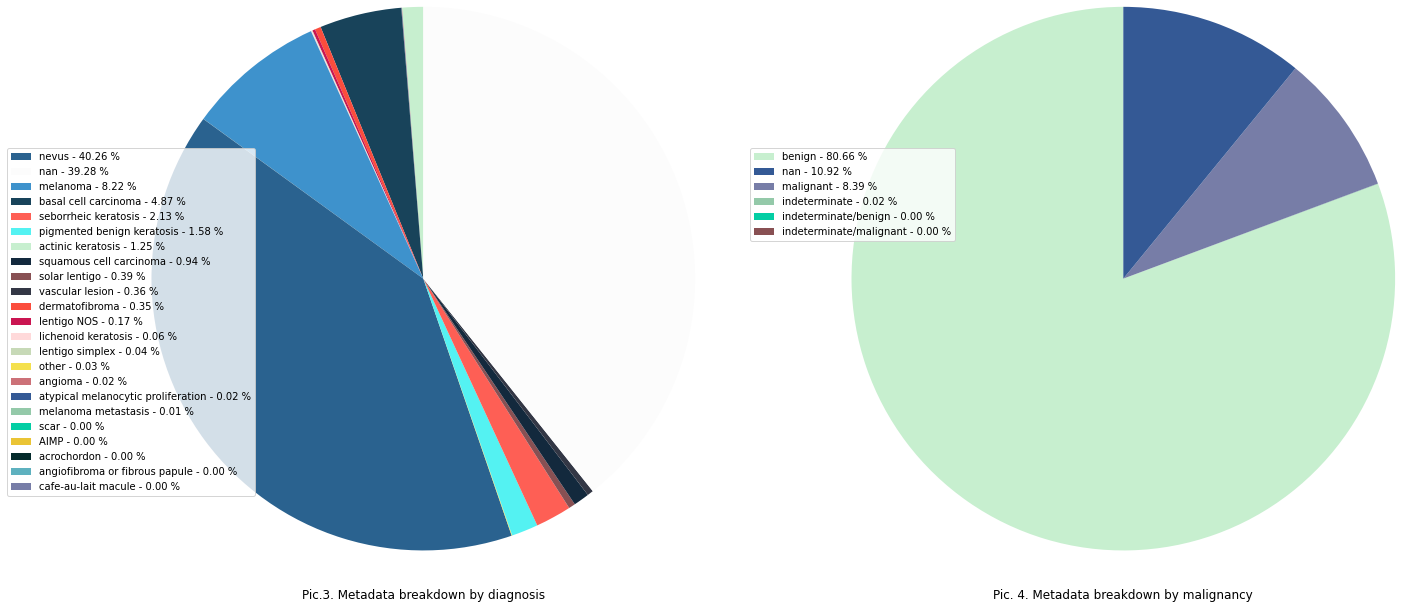

In [6]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = diagnosis_breaddown_metadata['size']
keys = diagnosis_breaddown_metadata['diagnosis']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic.3. Metadata breakdown by diagnosis')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = benign_malignant_breaddown_metadata['size']
keys = benign_malignant_breaddown_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 4. Metadata breakdown by malignancy')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

<a id='metadata_breakdowns'></a>
From the first pie chart, we see, that __39.28%__ samples don't have a diagnosis. We think, that the fact somehow correlates with the lesions' malignancy and the way the diagnosis' were obtained.

In [7]:
no_diagnosis_metadata = metadata[pd.isnull(metadata['diagnosis'])]

In [8]:
benign_malignant_breaddown_no_diagnosis_metadata = no_diagnosis_metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

In [9]:
diagnosis_confirm_type_breaddown_no_diagnosis_metadata = no_diagnosis_metadata.groupby(['diagnosis_confirm_type'], dropna=False, as_index=False).size()

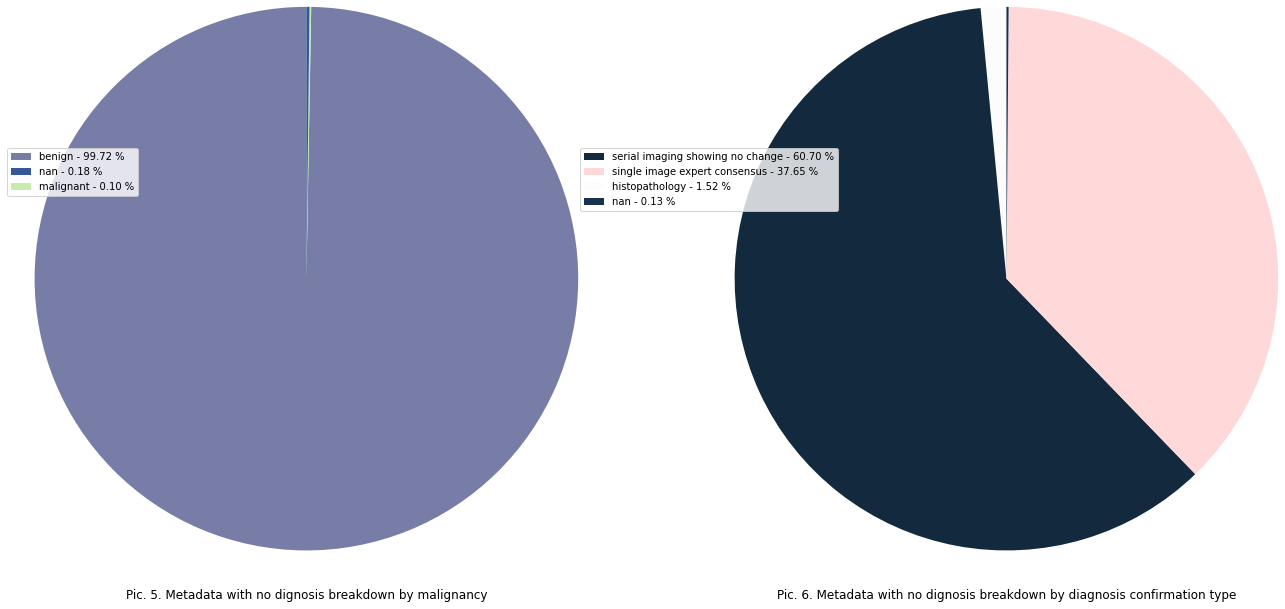

In [10]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = benign_malignant_breaddown_no_diagnosis_metadata['size']
keys = benign_malignant_breaddown_no_diagnosis_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic. 5. Metadata with no dignosis breakdown by malignancy')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = diagnosis_confirm_type_breaddown_no_diagnosis_metadata['size']
keys = diagnosis_confirm_type_breaddown_no_diagnosis_metadata['diagnosis_confirm_type']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 6. Metadata with no dignosis breakdown by diagnosis confirmation type')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

__99.72%__ of samples without a diagnosis are benign and only __1.52%__ are consirmed with histopathology research. 

Probably, because excision wasn't done, the hospital protocol allowed not to put exact diagnosis. But imaging researches were enough to conclude that the lesions were benign.

Let's see, what kind of research is made with the samples, which have diagnosis.

In [11]:
yes_diagnosis_metadata = metadata[pd.notnull(metadata['diagnosis'])]

In [12]:
benign_malignant_breaddown_yes_diagnosis_metadata = yes_diagnosis_metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

In [13]:
diagnosis_confirm_type_breaddown_yes_diagnosis_metadata = yes_diagnosis_metadata.groupby(['diagnosis_confirm_type'], dropna=False, as_index=False).size()

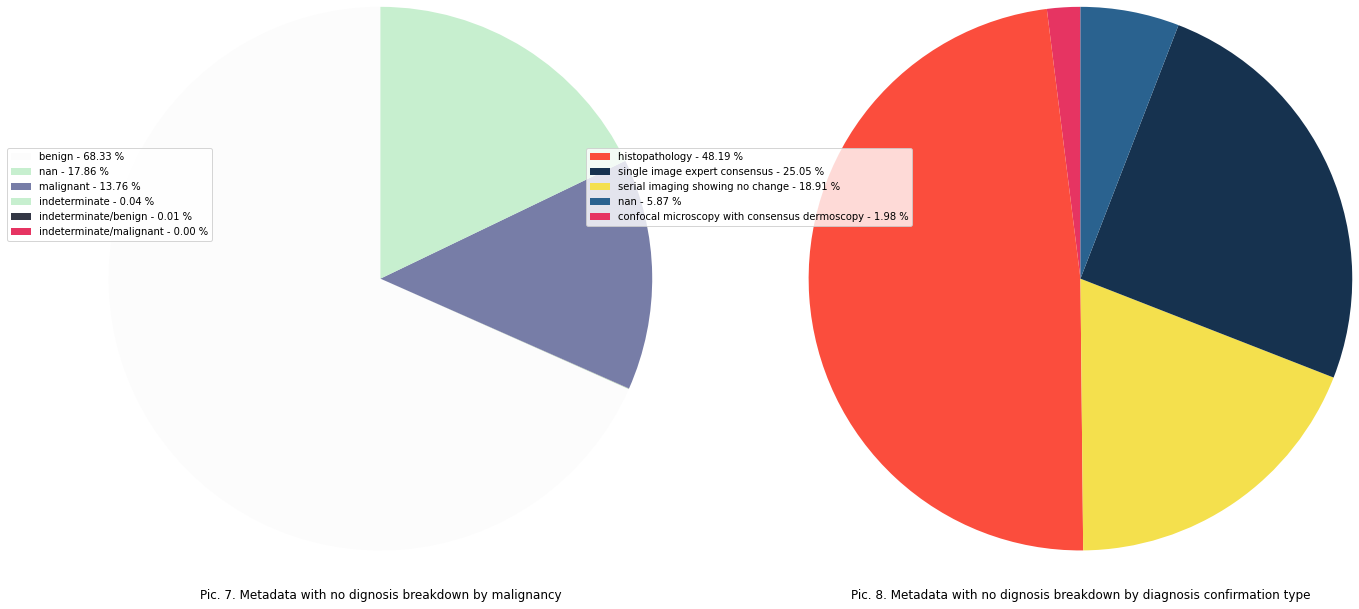

In [14]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = benign_malignant_breaddown_yes_diagnosis_metadata['size']
keys = benign_malignant_breaddown_yes_diagnosis_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic. 7. Metadata with no dignosis breakdown by malignancy')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = diagnosis_confirm_type_breaddown_yes_diagnosis_metadata['size']
keys = diagnosis_confirm_type_breaddown_yes_diagnosis_metadata['diagnosis_confirm_type']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 8. Metadata with no dignosis breakdown by diagnosis confirmation type')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

Out of the samples with diagnosis, much more of them were confirmed with a histopathological research - __48.18%__. But, and that's important, if a sample has a diagnosis, it doesn't mean, that it was confirmed with a histopathological research.

Let's go back to the [Pic. 4. Breakdown by malignancy](#metadata_breakdowns) . __10.92%__ of samples have unknown malignancy, so we will study it through diagnosis and other columns.

In [15]:
no_benign_malignant_metadata = metadata[pd.isnull(metadata['benign_malignant'])]

In [16]:
diagnosis_breakdown_no_benign_malignant_metadata = no_benign_malignant_metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()

In [17]:
diagnosis_confirm_type_no_benign_malignant_metadata = no_benign_malignant_metadata.groupby(['diagnosis_confirm_type'], dropna=False, as_index=False).size()

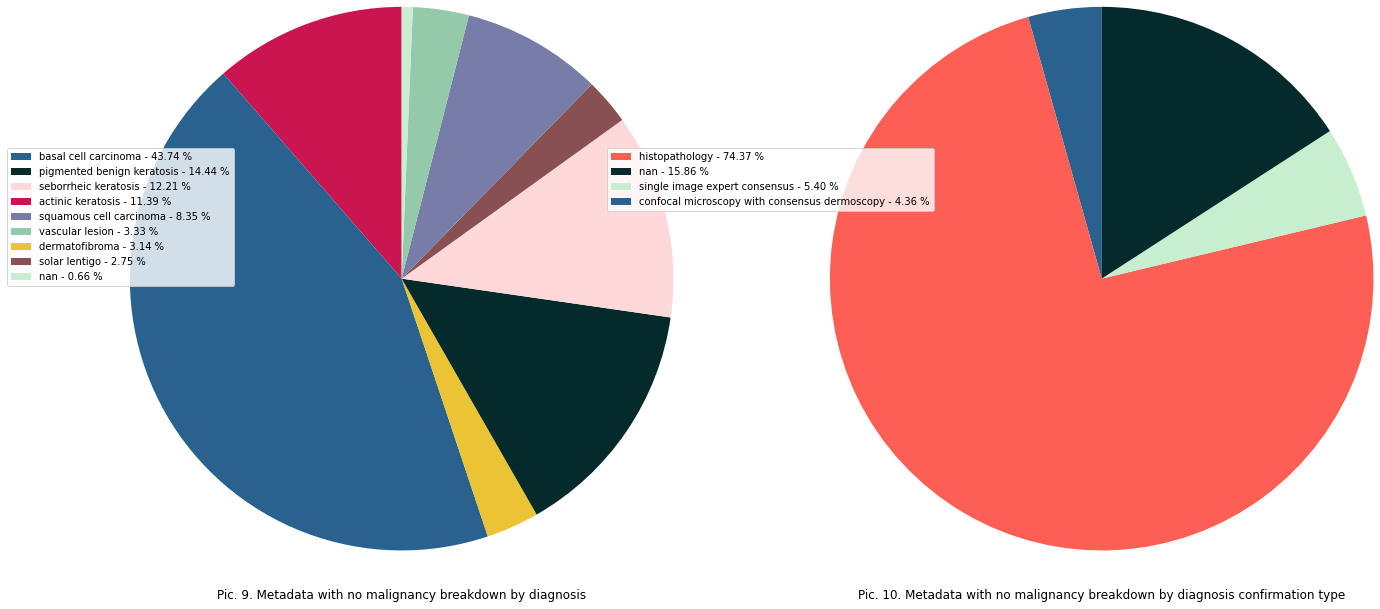

In [18]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = diagnosis_breakdown_no_benign_malignant_metadata['size']
keys = diagnosis_breakdown_no_benign_malignant_metadata['diagnosis']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic. 9. Metadata with no malignancy breakdown by diagnosis')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = diagnosis_confirm_type_no_benign_malignant_metadata['size']
keys = diagnosis_confirm_type_no_benign_malignant_metadata['diagnosis_confirm_type']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 10. Metadata with no malignancy breakdown by diagnosis confirmation type')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

For the most cases, the issues is with incorrectly filled data:
- [Basal-cell carcinoma](https://en.wikipedia.org/wiki/Basal-cell_carcinoma) - malignant
- Pigmented benign ketosis - benign
- [Seborrheic keratosis](https://en.wikipedia.org/wiki/Seborrheic_keratosis) - benign
- [Actinic keratosis](https://en.wikipedia.org/wiki/Actinic_keratosis) - precancerous, untreated lesions have up to a 20% risk of progression to squamous cell carcinoma, for our purposes, we'll consider it malignant
- [Squamous cell carcinoma](https://en.wikipedia.org/wiki/Squamous_cell_carcinoma) - malignant
- [Vascular lesion](https://en.wikipedia.org/wiki/Vascular_anomaly) - benign
- [Dermatofibroma](https://en.wikipedia.org/wiki/Dermatofibroma) - benign
- [Solar lentigo](https://en.wikipedia.org/wiki/Liver_spot) - benign

Let's fix the data

In [19]:
metadata.loc[metadata['diagnosis'] == 'basal cell carcinoma', 'benign_malignant']  = 'malignant'
metadata.loc[metadata['diagnosis'] == 'pigmented benign keratosis', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'seborrheic keratosis', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'actinic keratosis', 'benign_malignant']  = 'malignant'
metadata.loc[metadata['diagnosis'] == 'squamous cell carcinoma', 'benign_malignant']  = 'malignant'
metadata.loc[metadata['diagnosis'] == 'vascular lesion', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'dermatofibroma', 'benign_malignant']  = 'benign'
metadata.loc[metadata['diagnosis'] == 'solar lentigo', 'benign_malignant']  = 'benign'

Returning to samples without a diagnosis, we have two ways out of this:
- remove the samples
- introduce a new "label"

We don't know much about those samples except that they contain all kind of benign skin conditions. So, for example, there will be __solar lentigo__ samples in the __solar lentigo__ subset and the undiagnosed subset. That will may lead to classifying __solar lentigo__ as a part of undiagnosed subset. That's why, it's better to exclude the undiagnosed samples from training.

In addition to that, the dataset is tilted toward benign skin conditions, and almost all undiagnosed samples represent benign skin conditions. In that way, we not only remove confusing data but perform undersampling to balance out the dataset.

In [20]:
metadata = metadata.drop(metadata[pd.isnull(metadata['diagnosis'])].index)

Later on we will need to split the dataset into training, validation and testing. To do that, all diagnoses should have sufficient amount of  samples.

In [21]:
diagnosis_numbers = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size().sort_values(by='size')
diagnosis_numbers

,diagnosis,size
0,AIMP,1
1,acrochordon,1
3,angiofibroma or fibrous papule,1
7,cafe-au-lait macule,1
17,scar,3
13,melanoma metastasis,4
5,atypical melanocytic proliferation,14
4,angioma,15
15,other,24
10,lentigo simplex,27


We'll remove the samples, which are not part of the 10 most common diagnosis categories.

In [22]:
rare_diagnosis = diagnosis_numbers[:-10]['diagnosis']
rare_diagnosis

0                                   AIMP
1                            acrochordon
3         angiofibroma or fibrous papule
7                    cafe-au-lait macule
17                                  scar
13                   melanoma metastasis
5     atypical melanocytic proliferation
4                                angioma
15                                 other
10                       lentigo simplex
11                   lichenoid keratosis
9                            lentigo NOS
Name: diagnosis, dtype: object

In [23]:
metadata = metadata.drop(metadata[metadata['diagnosis'].isin(rare_diagnosis)].index)
metadata = metadata.drop(metadata[~metadata['benign_malignant'].isin(['benign', 'malignant'])].index)

Let's look at the breakdown now.

In [24]:
diagnosis_breaddown_metadata = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()

In [25]:
benign_malignant_breaddown_metadata = metadata.groupby(['benign_malignant'], dropna=False, as_index=False).size()

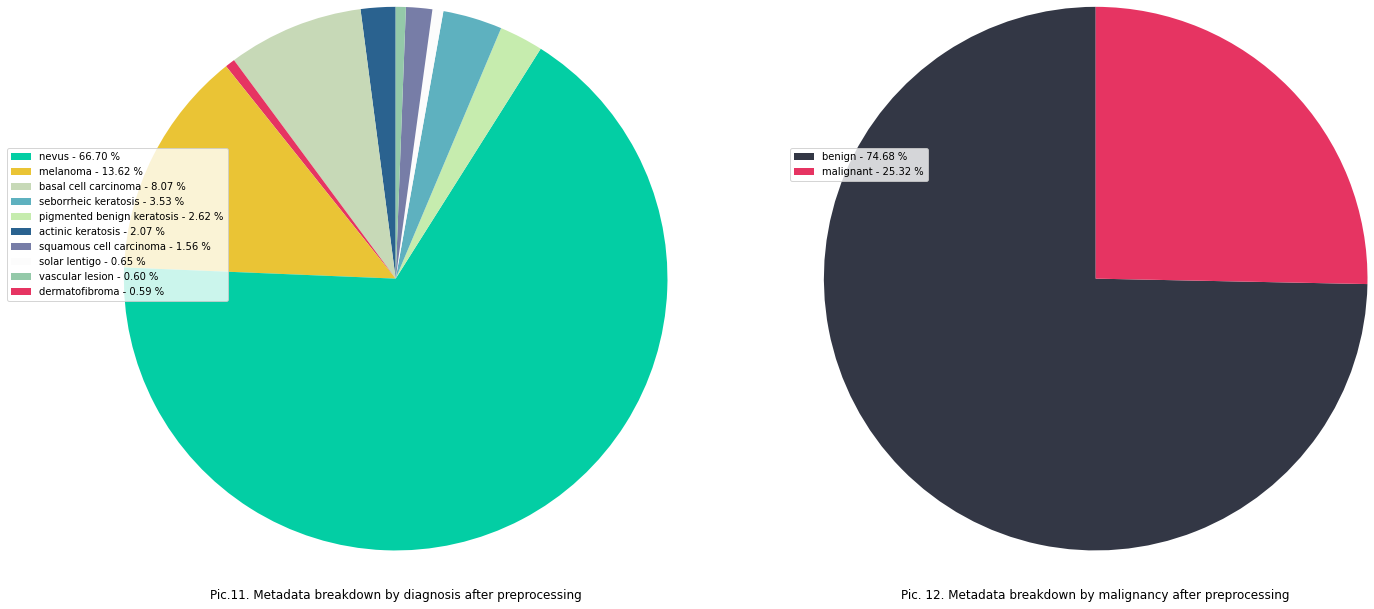

In [26]:
%matplotlib inline

plt.rcParams['axes.titley'] = -0.7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

# diagnosis plot
data = diagnosis_breaddown_metadata['size']
keys = diagnosis_breaddown_metadata['diagnosis']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
shuffle(palette_color)
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax1.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))
ax1.set_title('Pic.11. Metadata breakdown by diagnosis after preprocessing')
ax1.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

# diagnosis plot
data = benign_malignant_breaddown_metadata['size']
keys = benign_malignant_breaddown_metadata['benign_malignant']
palette_color = ['#333745', '#E63462', '#FE5F55', '#C7EFCF', '#C7EFCF', '#D5573B', '#885053', '#777DA7', '#94C9A9', '#C6ECAE', '#3E92CC', '#2A628F', '#13293D', '#16324F', '#18435A', '#F4E04D', '#FCFCFC', '#54F2F2', '#5EB1BF', '#042A2B', '#EAC435', '#345995', '#03CEA4', '#FB4D3D', '#CA1551', '#89023E', '#CC7178', '#FFD9DA', '#C7D9B7']
percentages = 100. * data / data.sum()

# plotting data on chart
patches, texts = ax2.pie(data, colors=palette_color, startangle=90, radius=2.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(keys, percentages)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                      key=lambda x: x[2],
                                      reverse=True))

ax2.set_title('Pic. 12. Metadata breakdown by malignancy after preprocessing')
ax2.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

The dataset is still imbalanced, so we'll calculate class weights to use them in training.

In [27]:
class_weights = metadata.groupby(['diagnosis'], dropna=False, as_index=False).size()
class_weights.loc[:, 'size'] =  1 / class_weights.loc[:, 'size']
class_weights.loc[:, 'size'] *= ( len(metadata) / 10 )
class_weights

,diagnosis,size
0,actinic keratosis,4.840506
1,basal cell carcinoma,1.238634
2,dermatofibroma,17.029960
3,melanoma,0.734229
4,nevus,0.149934
5,pigmented benign keratosis,3.824000
6,seborrheic keratosis,2.832593
7,solar lentigo,15.351825
8,squamous cell carcinoma,6.412195
9,vascular lesion,16.626087


In [28]:
class_weights = dict(enumerate(class_weights['size']))

We transform ISIC ids to filenames. 

In [29]:
metadata['isic_id'] += '.jpg'

We need to extract testing files from the dataset.

In [30]:
rest_set, testing_set = train_test_split(metadata, test_size=0.1)

Finally, we can load the images.

In [31]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.2, 1.5),
    validation_split=0.2
)

training_set = generator.flow_from_dataframe(
    rest_set,
    directory=f"{os.environ['SCRATCH']}/isic-archive",
    x_col='isic_id',
    y_col='diagnosis',
    
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training'
)

validation_set = generator.flow_from_dataframe(
    rest_set,
    directory=f"{os.environ['SCRATCH']}/isic-archive",
    x_col='isic_id',
    y_col='diagnosis',
    
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation'
)

testing_set = generator.flow_from_dataframe(
    testing_set,
    directory=f"{os.environ['SCRATCH']}/isic-archive",
    x_col='isic_id',
    y_col='diagnosis',
    
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical'
)

Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


In [32]:
CLASS_NUMBER = len(training_set.class_indices)

## Data source

As a data source, we use the ISIC Archive.

The ISIC Archive is an open source platform with publicly available images of skin lesions under Creative Commons licenses. The images are associated with ground-truth diagnoses and other clinical metadata. Images can be queried using faceted search and downloaded individually or in batches. The initial focus of the archive has been on dermoscopy images of individual skin lesions, as these images are inherently standardized by the use of a specialized acquisition device and devoid of many of the privacy challenges associated with clinical images. To date, the images have been provided by specialized melanoma centers from around the world. The archive is designed to accept contributions from new sources under the Terms of Use and welcomes new contributors. There are ongoing efforts to supplement the dermoscopy images in the archive with close-up clinical images and a broader representation of skin types. The images in the Archive are used to support educational efforts through linkage with Dermoscopedia and are used for Grand Challenges and Live Challenges to engage the computer science community for the development of diagnostic AI.

For more information, go to [ISIC Archive web site](https://www.isic-archive.com/)

# Model training

## Preparing TensorFlow callbacks

For our convenience, we create a few TensorFlow callbacks.

### The EarlyStopping callback

This callback stops training when the metrics (e.g. validation loss) are not improving,

In [33]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

## Define the distribution strategy

In [34]:
strategy = tf.distribute.MirroredStrategy()

## Actual training

In [35]:
with strategy.scope():
    model = LesionClassifier(class_number=CLASS_NUMBER)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
    ]
)

Epoch 1/30
947/947 [==============================] - 4412s 4s/step - loss: 43.5395 - accuracy: 0.6870 - val_loss: 0.8393 - val_accuracy: 0.7364
Epoch 2/30
947/947 [==============================] - 4629s 5s/step - loss: 0.7218 - accuracy: 0.7571 - val_loss: 0.7247 - val_accuracy: 0.7451
Epoch 3/30
947/947 [==============================] - 4355s 5s/step - loss: 0.6602 - accuracy: 0.7734 - val_loss: 0.6784 - val_accuracy: 0.7704
Epoch 4/30
947/947 [==============================] - 4165s 4s/step - loss: 0.6317 - accuracy: 0.7808 - val_loss: 0.6601 - val_accuracy: 0.7793
Epoch 5/30
947/947 [==============================] - 4104s 4s/step - loss: 0.5980 - accuracy: 0.7920 - val_loss: 0.6490 - val_accuracy: 0.7764
Epoch 6/30
947/947 [==============================] - 4042s 4s/step - loss: 0.5738 - accuracy: 0.8007 - val_loss: 0.6265 - val_accuracy: 0.7838
Epoch 7/30
947/947 [==============================] - 4234s 4s/step - loss: 0.5473 - accuracy: 0.8088 - val_loss: 0.6079 - val_accuracy

## Making diagnoses

In [37]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [38]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 462s 3s/step


## Plot the ROC Curve

In [39]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in testing_set.class_indices.items()}

for i in range(len(diagnosis_index_dict)):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

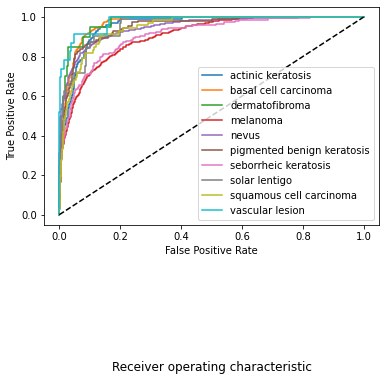

In [40]:
%matplotlib inline 
for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Show AUC

In [41]:
auc_metric

{'actinic keratosis': 0.9554966444555898,
 'basal cell carcinoma': 0.9674963078118928,
 'dermatofibroma': 0.9744088846429424,
 'melanoma': 0.9040673155383988,
 'nevus': 0.9487859450763964,
 'pigmented benign keratosis': 0.9513714460143031,
 'seborrheic keratosis': 0.9088617727514794,
 'solar lentigo': 0.9565643712574851,
 'squamous cell carcinoma': 0.9456603520085987,
 'vascular lesion': 0.9795182475683764}